# Binary Classification models 

Meausuring performance of other ML methods. This time utilising bianry classification systems 

Each unvalidated count is binned as either high or low risk 

Depending on if the mean number of unalidated people within the given granulatity level at that given bus stop is above 1 

The ML methods tested are : Random forest, MLP classifier, XGBoost

Peformance was based on the area under the receiver operater curve (auc_roc)

It should be acknoledged that a more sophisticated classification could be used - such as low, medium and high. or other variations. This threshold of 1 was chosen by looking at the "Frequency of Unvalidated Individuals per Bus" plot in 1_Compiling_data/Pipe3

In [22]:
import pandas as pd
from sklearn.metrics import roc_auc_score, r2_score

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier 
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt 
import glob 
import os

### Transorming data for the binary task

In [36]:
def Transform_data(df):
    """
    splits into X and Y 
    and applies SMOTE
    Returns a df ready for MLP regressor, and Random forest
    """
    # Features and target
    X = df.drop(columns=["Unvalidated_mean", "Risk_level"])
    y = df["Risk_level"]
    
    # One-hot encode categorical features
    X = pd.get_dummies(X)
    
    # Scale numeric features
    numeric_cols = ["density", "Visiting_score", "Rel_Visiting_score", "Validation_Count_mean"]
    scaler = StandardScaler()
    X[numeric_cols] = scaler.fit_transform(X[numeric_cols])
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Apply SMOTE to balance classes in training set
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    return X_train_res, y_train_res, X_test, y_test


### Random forest method

In [45]:

def Random_forest(X_train_res, y_train_res, X_test, y_test):
    # Train Random Forest
    rf = RandomForestClassifier(
        n_estimators=1000,
        max_depth=None,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    
    rf.fit(X_train_res, y_train_res)
    
    # Predictions and metrics
    y_prob = rf.predict_proba(X_test)[:,1]
    roc_auc = roc_auc_score(y_test, y_prob)

    return roc_auc


### MLP_classifier method

In [46]:
def MLP_classifier(X_train_res, y_train_res, X_test, y_test):
    # Train a MLP model
    NN = MLPClassifier(
        hidden_layer_sizes=(128, 128, 128, 128, 64, 32),
        activation="relu",
        solver="adam",
        alpha=1e-4,
        max_iter=500,
        early_stopping=True,
        validation_fraction=0.1,
        random_state=42
    )
    
    NN.fit(X_train_res, y_train_res)
    
    # Predictions and metrics
    y_prob = NN.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_prob)
    return roc_auc

### XGboost method

In [47]:
def XGBoost_classifier(X_train_res, y_train_res, X_test, y_test):
    
    # XGBoost model
    xgb = XGBClassifier(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=None,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,        # L2 regularization
        reg_alpha=0.0,         # L1 (can try >0 for sparsity)
        scale_pos_weight=1.0,  # since you used SMOTE, no imbalance weight needed
        objective='binary:logistic',
        eval_metric='auc',
        random_state=42,
        n_jobs=-1
    )
    
    # Fit on resampled data
    xgb.fit(X_train_res, y_train_res)
    
    # Predict probabilities on test set
    y_prob = xgb.predict_proba(X_test)[:, 1]
    
    # ROC-AUC evaluation
    roc_auc = roc_auc_score(y_test, y_prob)

    
    return roc_auc


### ROC and R2 function

In [48]:
def Analyse_ROC(Performance, model_name):
    
    rf_performance = pd.DataFrame(Performance, columns = ["Name", "ROC_AUC"])
    rf_performance.sort_values(by = "ROC_AUC", inplace = True, ascending = False)
    
    sns.barplot(data = rf_performance, x = "Name", y = "ROC_AUC")
    plt.xticks(rotation = 90)

    plt.savefig(f"c:/users/henry chapman/Documents/Coding/Data_science/Project_final/Output/3_ML_performance/Pipe2/{model_name}_ROC_AUC.svg", format='svg', bbox_inches='tight')
    
    plt.show()

### Master function

In [51]:
def Run_Model(Model):
    """
    Runs either MLP classifer or randomforest makes a chart showing the ROC_AUC curves
    """
    
    Performance = []

    
    files = glob.glob("c:/users/henry chapman/Documents/Coding/Data_science/Project_final/Output/2_Granularity_tuning/Pipe2/*.csv")
    for file in files:
        Name = os.path.basename(file).split(".")[0]
        df = pd.read_csv(file)
        df.drop(columns = ["Unnamed: 0"], inplace = True)
        # High risk is simply those with a value greater than the mean 
        High_risk_thresh = df["Unvalidated_mean"].mean()
    
        df["Risk_level"] = df["Unvalidated_mean"].map(lambda x : 1 if x > High_risk_thresh else 0)

        Transformed_df = Transform_data(df)

        if Model == "Random_forest":
            roc_auc = Random_forest(*Transformed_df)
            Performance.append([Name, roc_auc])
        elif Model == "MLP_Classifier":
            roc_auc = Random_forest(*Transformed_df)
            Performance.append([Name, roc_auc])

        elif Model == "XGBoost_classifier":
            roc_auc = XGBoost_classifier(*Transformed_df)
            Performance.append([Name, roc_auc])
        else: 
            print("Please specefic model name, either Random_forest, MLP_Classifier or XGBoost_classifier")
                  
    Analyse_ROC(Performance, Model)
    

## Random Forest 

In [ ]:
# Creatintg graph for powerpoint 

#120 min weekend split 
["XGBoost", "RandomForest", "MLPClassifier"]
[0.7, 0.69, 0.68]

#30 min collapse all
[0.66, 0.64, 0.65]

# 720 min day of week 
[0.66, 0.65, 0.65]

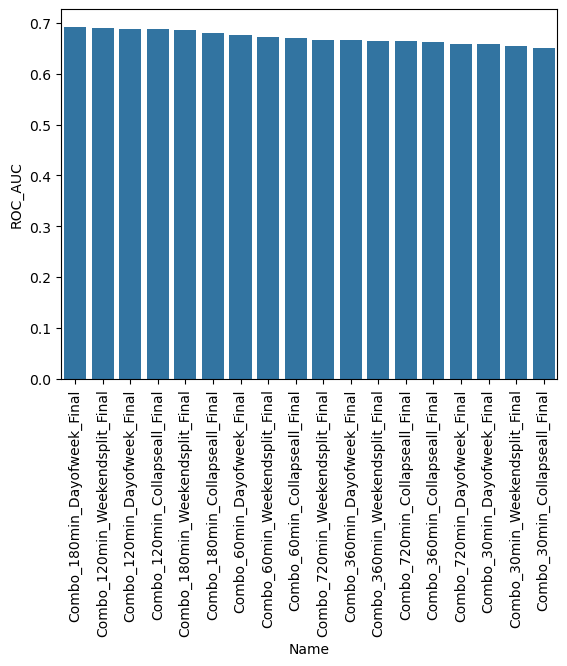

In [52]:
Run_Model("Random_forest")

### MLP classifier'

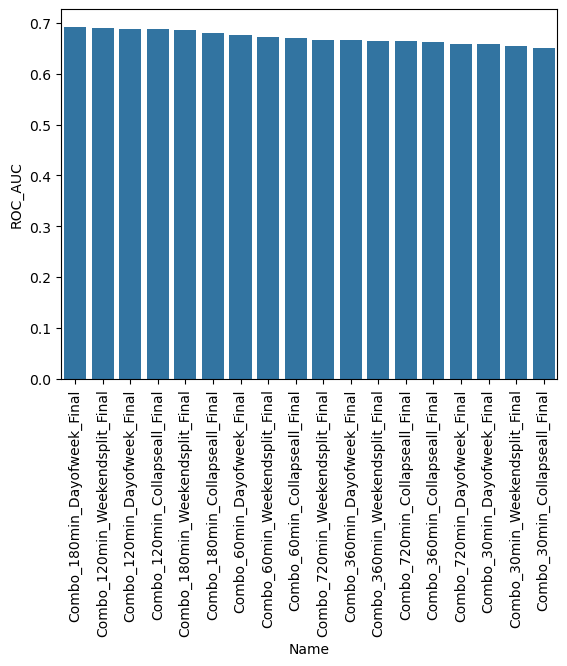

In [53]:
Run_Model("MLP_Classifier")

### XG Boost

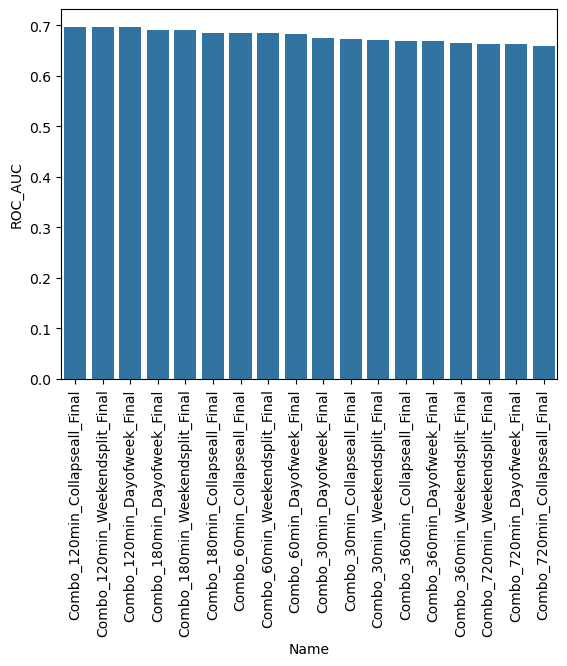

In [54]:
Run_Model("XGBoost_classifier")